In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import os
from tqdm import tqdm

calphad_results_dir = '../'
print("calphad results directory:", os.path.abspath(calphad_results_dir))

ML_results_dir = './v6_A-B-C-D-E_Sputtering_ML/v6_A-B-C-D-E_Sputtering_ML_All/'
print("")
print("ML results directory:", os.path.abspath(ML_results_dir))


calphad results directory: /nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering

ML results directory: /nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/v6_A-B-C-D-E_Sputtering_ML/v6_A-B-C-D-E_Sputtering_ML_All


### Creating lists of compositions and labels


In [3]:
# Define the set of elements for D and E
set_D_E = [{'Co'}, {'V'}, {'Mn'}, {'Mo'}, {'Cu'},
           {'Nb'}, {'W'}, {'Ti'}, {'Al'}, {'Si'}, {'Ta'}]

# Generate all possible combinations of D and E
compo_D_E_list = list(combinations(set_D_E, 2))

compo_A_B_C_D_E_list = []
compo_A_B_C_D_E_label_list = []

for compo_D_E in compo_D_E_list:
    # Convert the current combination to a list and flatten it
    compo_D_E_list = [item for sublist in compo_D_E for item in sublist]

    # Define the current combination of A, B, C, D, E
    compo_A_B_C_D_E = ['Fe', 'Cr', 'Ni'] + compo_D_E_list
    compo_A_B_C_D_E_merge = '_'.join([*compo_A_B_C_D_E])

    compo_A_B_C_D_E_label_merge = '-'.join([*compo_A_B_C_D_E])
    compo_A_B_C_D_E_list.append(compo_A_B_C_D_E_merge)
    compo_A_B_C_D_E_label_list.append(compo_A_B_C_D_E_label_merge)

print(compo_A_B_C_D_E_list[0])
print(compo_A_B_C_D_E_label_list[0])


Fe_Cr_Ni_Co_V
Fe-Cr-Ni-Co-V


### Reads in relevant data, performs data manipulations, and saves the updated dataframes to files


In [4]:
# Define a list of compositions to iterate over
# compo_A_B_C_D_E_list = ['Fe_Cr_Ni_Mn_Ta', 'Fe_Cr_Ni_Mn_Ti', 'Fe_Cr_Ni_Mn_W']

# Initialize lists to hold dataframes
fcc_fractions_byPalette_list = []
SSS_fcc_byCompo_list = []
H1_C2_mean_std_fcc_byCompo_list = []

# Loop over each composition and read in relevant data
for compo_A_B_C_D_E_fname, compo_A_B_C_D_E_label in tqdm(zip(compo_A_B_C_D_E_list, compo_A_B_C_D_E_label_list)):
    print("")
    print(compo_A_B_C_D_E_label)

    # ----- read `count_fcc_fractions_byPalette` -----
    # Read in the FCC phase stability dataframe and add composition label
    fcc_fractions_byPalette = pd.read_excel(calphad_results_dir +
                                            'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/count_fcc_fractions_byPalette.xlsx')
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        compo_A_B_C_D_E=compo_A_B_C_D_E_label)

    # Add labels for FCC phase stability types
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        Gmin_FCC='min Gibbs energy')
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        eq_FCC='full equilibrium')

    # Append the updated dataframe to the list
    fcc_fractions_byPalette_list.append(fcc_fractions_byPalette)

    # ----- Read `SSS_byCompo` and `count_fcc_fractions_byCompo` -----
    # Read in the SSS and FCC fractions by composition dataframes
    SSS_byCompo = pd.read_excel(calphad_results_dir +
                                'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_byCompo.xlsx')
    fcc_fractions_byCompo = pd.read_excel(calphad_results_dir +
                                          'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/count_fcc_fractions_byCompo.xlsx')

    # Merge the two dataframes
    SSS_fcc_byCompo = pd.concat([SSS_byCompo, fcc_fractions_byCompo[[
                                'Gmin_FCC', 'eq_FCC', 'Gmin_eq_FCC']]], axis=1)

    # Create a new column 'sigma_SSS_FCC' for SSS values corresponding to FCC phase stability
    SSS_fcc_byCompo['sigma_SSS_FCC'] = SSS_fcc_byCompo.loc[SSS_fcc_byCompo['Gmin_eq_FCC'] == 1, 'sigma_SSS']
    SSS_fcc_byCompo = SSS_fcc_byCompo.assign(
        compo_A_B_C_D_E=compo_A_B_C_D_E_label)

    # Saving the new `SSS_FCC_byCompo.xlsx`
    if os.path.exists(calphad_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_FCC_byCompo.xlsx'):
        print('SSS_FCC_byCompo.xlsx: File already exists.')
    else:
        SSS_fcc_byCompo.to_excel(calphad_results_dir +
                                 'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_FCC_byCompo.xlsx', index=False)
        print('Saving '+'v6_' + compo_A_B_C_D_E_fname +
              '_Sputtering' + '/SSS_FCC_byCompo.xlsx')

    # Append the updated dataframe to the list
    SSS_fcc_byCompo_list.append(SSS_fcc_byCompo)

    # ----------------------------------------------------------------------------------------------------
    H1_C2_mean_std_fcc_byCompo = pd.read_excel(
        ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML.xlsx')

    # Create a new column 'sigma_SSS_FCC' for SSS values corresponding to FCC phase stability
    H1_C2_mean_std_fcc_byCompo['H1_new_pred_KFold_mean_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'H1_new_pred_KFold_mean']
    H1_C2_mean_std_fcc_byCompo['H1_new_pred_KFold_std_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'H1_new_pred_KFold_std']
    H1_C2_mean_std_fcc_byCompo['C2_new_pred_KFold_mean_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'C2_new_pred_KFold_mean']
    H1_C2_mean_std_fcc_byCompo['C2_new_pred_KFold_std_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'C2_new_pred_KFold_std']

    # Saving the excel: H1 C2 when FCC==1
    if os.path.exists(ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx'):
        print('SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.')
        # H1_C2_mean_std_fcc_byCompo.to_excel(ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx')
    else:
        H1_C2_mean_std_fcc_byCompo.to_excel(
            ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx')
        print('Saving ' + 'v6_' + compo_A_B_C_D_E_fname +
              '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx')

    # Append the updated dataframe to the list
    H1_C2_mean_std_fcc_byCompo_list.append(H1_C2_mean_std_fcc_byCompo)

    # ----------------------------------------------------------------------------------------------------

# Display the first two rows of the loaded dataframes
display(fcc_fractions_byPalette_list[0].head(2))
display(SSS_fcc_byCompo_list[0].head(2))
display(H1_C2_mean_std_fcc_byCompo_list[0].head(2))


0it [00:00, ?it/s]


Fe-Cr-Ni-Co-V
SSS_FCC_byCompo.xlsx: File already exists.


1it [00:04,  4.44s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-Mn
SSS_FCC_byCompo.xlsx: File already exists.


2it [00:08,  4.06s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-Mo
SSS_FCC_byCompo.xlsx: File already exists.


3it [00:12,  4.19s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-Cu
SSS_FCC_byCompo.xlsx: File already exists.


4it [00:16,  3.99s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-Nb
SSS_FCC_byCompo.xlsx: File already exists.


5it [00:19,  3.85s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-W
SSS_FCC_byCompo.xlsx: File already exists.


6it [00:23,  3.67s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-Ti
SSS_FCC_byCompo.xlsx: File already exists.


7it [00:28,  4.09s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-Al
SSS_FCC_byCompo.xlsx: File already exists.


8it [00:32,  4.04s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-Si
SSS_FCC_byCompo.xlsx: File already exists.


9it [00:35,  3.89s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Co-Ta
SSS_FCC_byCompo.xlsx: File already exists.


10it [00:39,  3.82s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-Mn
SSS_FCC_byCompo.xlsx: File already exists.


11it [00:42,  3.75s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-Mo
SSS_FCC_byCompo.xlsx: File already exists.


12it [00:46,  3.64s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-Cu
SSS_FCC_byCompo.xlsx: File already exists.


13it [00:49,  3.64s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-Nb
SSS_FCC_byCompo.xlsx: File already exists.


14it [00:53,  3.70s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-W
SSS_FCC_byCompo.xlsx: File already exists.


15it [00:57,  3.62s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-Ti
SSS_FCC_byCompo.xlsx: File already exists.


16it [01:00,  3.63s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-Al
SSS_FCC_byCompo.xlsx: File already exists.


17it [01:04,  3.61s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-Si
SSS_FCC_byCompo.xlsx: File already exists.


18it [01:07,  3.58s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-V-Ta
SSS_FCC_byCompo.xlsx: File already exists.


19it [01:11,  3.54s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mn-Mo
SSS_FCC_byCompo.xlsx: File already exists.


20it [01:15,  3.59s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mn-Cu
SSS_FCC_byCompo.xlsx: File already exists.


21it [01:18,  3.56s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mn-Nb
SSS_FCC_byCompo.xlsx: File already exists.


22it [01:22,  3.55s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mn-W
SSS_FCC_byCompo.xlsx: File already exists.


23it [01:25,  3.57s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mn-Ti
SSS_FCC_byCompo.xlsx: File already exists.


24it [01:29,  3.76s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mn-Al
SSS_FCC_byCompo.xlsx: File already exists.


25it [01:33,  3.73s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mn-Si
SSS_FCC_byCompo.xlsx: File already exists.


26it [01:37,  3.70s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mn-Ta
SSS_FCC_byCompo.xlsx: File already exists.


27it [01:40,  3.64s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mo-Cu
SSS_FCC_byCompo.xlsx: File already exists.


28it [01:44,  3.64s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mo-Nb
SSS_FCC_byCompo.xlsx: File already exists.


29it [01:48,  3.67s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mo-W
SSS_FCC_byCompo.xlsx: File already exists.


30it [01:51,  3.61s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mo-Ti
SSS_FCC_byCompo.xlsx: File already exists.


31it [01:55,  3.66s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mo-Al
SSS_FCC_byCompo.xlsx: File already exists.


32it [01:58,  3.65s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mo-Si
SSS_FCC_byCompo.xlsx: File already exists.


33it [02:02,  3.65s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Mo-Ta
SSS_FCC_byCompo.xlsx: File already exists.


34it [02:06,  3.78s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Cu-Nb
SSS_FCC_byCompo.xlsx: File already exists.


35it [02:10,  3.76s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Cu-W
SSS_FCC_byCompo.xlsx: File already exists.


36it [02:13,  3.70s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Cu-Ti
SSS_FCC_byCompo.xlsx: File already exists.


37it [02:17,  3.69s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Cu-Al
SSS_FCC_byCompo.xlsx: File already exists.


38it [02:21,  3.63s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Cu-Si
SSS_FCC_byCompo.xlsx: File already exists.


39it [02:24,  3.61s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Cu-Ta
SSS_FCC_byCompo.xlsx: File already exists.


40it [02:28,  3.59s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Nb-W
SSS_FCC_byCompo.xlsx: File already exists.


41it [02:32,  3.73s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Nb-Ti
SSS_FCC_byCompo.xlsx: File already exists.


42it [02:35,  3.66s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Nb-Al
SSS_FCC_byCompo.xlsx: File already exists.


43it [02:39,  3.65s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Nb-Si
SSS_FCC_byCompo.xlsx: File already exists.


44it [02:42,  3.61s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Nb-Ta
SSS_FCC_byCompo.xlsx: File already exists.


45it [02:46,  3.68s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-W-Ti
SSS_FCC_byCompo.xlsx: File already exists.


46it [02:50,  3.66s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-W-Al
SSS_FCC_byCompo.xlsx: File already exists.


47it [02:54,  3.68s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-W-Si
SSS_FCC_byCompo.xlsx: File already exists.


48it [02:57,  3.67s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-W-Ta
SSS_FCC_byCompo.xlsx: File already exists.


49it [03:01,  3.64s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Ti-Al
SSS_FCC_byCompo.xlsx: File already exists.


50it [03:04,  3.58s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Ti-Si
SSS_FCC_byCompo.xlsx: File already exists.


51it [03:08,  3.58s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Ti-Ta
SSS_FCC_byCompo.xlsx: File already exists.


52it [03:11,  3.56s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Al-Si
SSS_FCC_byCompo.xlsx: File already exists.


53it [03:15,  3.62s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Al-Ta
SSS_FCC_byCompo.xlsx: File already exists.


54it [03:19,  3.60s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

Fe-Cr-Ni-Si-Ta
SSS_FCC_byCompo.xlsx: File already exists.


55it [03:22,  3.69s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.


,ABCDE,Gmin_FCC_fraction,eq_FCC_fraction,Gmin_eq_FCC_fraction,compo_A_B_C_D_E,Gmin_FCC,eq_FCC
0,V-Co-Ni-Cr-Fe,57.971014,44.927536,44.927536,Fe-Cr-Ni-Co-V,min Gibbs energy,full equilibrium
1,V-Co-Ni-Fe-Cr,55.072464,52.173913,49.275362,Fe-Cr-Ni-Co-V,min Gibbs energy,full equilibrium


,Fe,Cr,Ni,Co,V,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,Gmin_FCC,eq_FCC,Gmin_eq_FCC,sigma_SSS_FCC,compo_A_B_C_D_E
0,0.33,0.03,0.05,0.12,0.47,63.740744,0.329844,0.092273,456.766541,0,0.0,0,NaN,Fe-Cr-Ni-Co-V
1,0.39,0.05,0.05,0.11,0.40,66.837689,0.322980,0.091240,464.791066,0,0.0,0,NaN,Fe-Cr-Ni-Co-V


,Unnamed: 0,Fe,Cr,Ni,Co,V,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,...,sigma_SSS_FCC,compo_A_B_C_D_E,H1_new_pred_KFold_mean,H1_new_pred_KFold_std,C2_new_pred_KFold_mean,C2_new_pred_KFold_std,H1_new_pred_KFold_mean_FCC,H1_new_pred_KFold_std_FCC,C2_new_pred_KFold_mean_FCC,C2_new_pred_KFold_std_FCC
0,0,34.167395,2.891940,5.441344,13.111107,44.388214,63.740744,0.329844,0.092273,456.766541,...,NaN,Fe-Cr-Ni-Co-V,378.698212,173.712723,200.080307,347.795746,NaN,NaN,NaN,NaN
1,1,40.204113,4.798947,5.417690,11.966268,37.612981,66.837689,0.322980,0.091240,464.791066,...,NaN,Fe-Cr-Ni-Co-V,413.697540,166.767456,255.091766,289.118958,NaN,NaN,NaN,NaN


### Rank the sequence of ABCDE by `Gmin_eq_FCC_max`


In [5]:
# ----- rank by `Gmin_eq_FCC_mean`
# # Calculate the mean of the Gmin_eq_FCC_fraction for each set of data and rank them in descending order
# Gmin_eq_FCC_mean = [np.mean(fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values)
#                     for fcc_fractions_byPalette in fcc_fractions_byPalette_list]
# print(Gmin_eq_FCC_mean)

# ranked_indices = np.argsort(Gmin_eq_FCC_mean)[::-1]  # Sort in descending order

# Gmin_eq_FCC_mean_sort = [Gmin_eq_FCC_mean[i] for i in ranked_indices]  # Sort the mean values in the ranked order
# print(Gmin_eq_FCC_mean_sort)


# ----- rank by `Gmin_eq_FCC_max`
# Calculate the max of the Gmin_eq_FCC_fraction for each set of data and rank them in descending order
Gmin_eq_FCC_max = [np.max(fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values)
                   for fcc_fractions_byPalette in fcc_fractions_byPalette_list]
print(Gmin_eq_FCC_max)

ranked_indices = np.argsort(Gmin_eq_FCC_max)[::-1]  # Sort in descending order

# Sort the mean values in the ranked order
Gmin_eq_FCC_max_sort = [Gmin_eq_FCC_max[i] for i in ranked_indices]
print(Gmin_eq_FCC_max_sort)

# Sort the list of dataframes based on the ranked order of mean values
compo_A_B_C_D_E_sort_list = [compo_A_B_C_D_E_list[i] for i in ranked_indices]
print(compo_A_B_C_D_E_sort_list)

fcc_fractions_byPalette_sort_list = [
    fcc_fractions_byPalette_list[i] for i in ranked_indices]
SSS_fcc_byCompo_sort_list = [SSS_fcc_byCompo_list[i] for i in ranked_indices]

H1_C2_mean_std_fcc_byCompo_sort_list = [
    H1_C2_mean_std_fcc_byCompo_list[i] for i in ranked_indices]


[50.72463768115942, 79.71014492753623, 17.391304347826086, 34.78260869565217, 17.391304347826086, 24.637681159420293, 30.434782608695656, 36.231884057971016, 43.47826086956522, 17.391304347826086, 28.985507246376812, 18.84057971014493, 21.73913043478261, 11.594202898550725, 10.144927536231885, 11.594202898550725, 15.942028985507244, 18.84057971014493, 7.246376811594203, 36.231884057971016, 44.927536231884055, 13.043478260869565, 15.942028985507244, 24.637681159420293, 30.434782608695656, 26.08695652173913, 11.594202898550725, 23.18840579710145, 8.695652173913043, 5.797101449275362, 11.594202898550725, 17.391304347826086, 10.144927536231885, 4.3478260869565215, 10.144927536231885, 8.695652173913043, 18.84057971014493, 21.73913043478261, 15.942028985507244, 4.3478260869565215, 4.3478260869565215, 2.898550724637681, 8.695652173913043, 2.898550724637681, 0, 4.3478260869565215, 5.797101449275362, 2.898550724637681, 1.4492753623188406, 11.594202898550725, 11.594202898550725, 1.44927536231884

### Modify the dataframe for plotting: `fcc_fractions_byPalette_sort_list`


In [6]:
# Create an empty list to store the modified dataframes
df_fcc_byPalette_sns_new_list = []

# Loop over each dataframe in the list of sorted FCC fractions by palette
for df_fcc_byPalette_sns in fcc_fractions_byPalette_sort_list:

    # Select the desired columns for the first dataframe and rename the columns
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns[['ABCDE', 'Gmin_FCC_fraction', 'Gmin_FCC',
                                                  'Gmin_eq_FCC_fraction', 'compo_A_B_C_D_E']]
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns1.rename(
        columns={'Gmin_FCC': 'minG vs.full equil.'})
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns1.rename(
        columns={'Gmin_FCC_fraction': 'Gmin_vs_eq_FCC_fraction'})

    # Select the desired columns for the second dataframe and rename the columns
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns[['ABCDE', 'eq_FCC_fraction', 'eq_FCC',
                                                  'compo_A_B_C_D_E']]
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns2.rename(
        columns={'eq_FCC': 'minG vs.full equil.'})
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns2.rename(
        columns={'eq_FCC_fraction': 'Gmin_vs_eq_FCC_fraction'})

    # Concatenate the two dataframes vertically
    df_fcc_byPalette_sns_new = pd.concat(
        [df_fcc_byPalette_sns1, df_fcc_byPalette_sns2], axis=0)

    # Add the modified dataframe to the list
    df_fcc_byPalette_sns_new_list.append(df_fcc_byPalette_sns_new)


### Check dataframes to be plotted

- `df_fcc_sns`
- `df_fcc_sns_30`
- `df_SSS_sns`
- `df_SSS_sns_30`
- `df_H1_C2_sns`
- `df_H1_C2_sns_30`


In [7]:
# Concatenate the modified dataframes in the list vertically to create a new dataframe
df_fcc_sns = pd.concat(df_fcc_byPalette_sns_new_list, axis=0)
df_fcc_sns_30 = pd.concat(df_fcc_byPalette_sns_new_list[0:30], axis=0)

# Concatenate the list of SSS dataframes vertically to create a new dataframe
df_SSS_sns = pd.concat(SSS_fcc_byCompo_sort_list, axis=0)
df_SSS_sns_30 = pd.concat(SSS_fcc_byCompo_sort_list[0:30], axis=0)

# Concatenate the list of H1_C2 dataframes vertically to create a new dataframe
df_H1_C2_sns = pd.concat(H1_C2_mean_std_fcc_byCompo_sort_list, axis=0)
df_H1_C2_sns_30 = pd.concat(H1_C2_mean_std_fcc_byCompo_sort_list[0:30], axis=0)

# Display the first row of the new SSS dataframe
display(df_fcc_sns.head(1))
display(df_SSS_sns.head(1))
display(df_H1_C2_sns.head(1))
display(df_H1_C2_sns.columns)


,ABCDE,Gmin_vs_eq_FCC_fraction,minG vs.full equil.,Gmin_eq_FCC_fraction,compo_A_B_C_D_E
0,Mn-Co-Ni-Cr-Fe,60.869565,min Gibbs energy,59.42029,Fe-Cr-Ni-Co-Mn


,Fe,Cr,Ni,Co,Mn,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,Gmin_FCC,...,compo_A_B_C_D_E,V,Cu,Si,Al,Mo,Ti,W,Nb,Ta
0,0.33,0.03,0.05,0.12,0.47,81.342074,0.266533,0.041722,133.665273,1.0,...,Fe-Cr-Ni-Co-Mn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Unnamed: 0,Fe,Cr,Ni,Co,Mn,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,...,C2_new_pred_KFold_std_FCC,V,Cu,Si,Al,Mo,Ti,W,Nb,Ta
0,0,33.017598,2.794621,5.258233,12.669893,46.259655,81.342074,0.266533,0.041722,133.665273,...,350.084106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['Unnamed: 0', 'Fe', 'Cr', 'Ni', 'Co', 'Mn', 'ShearModulus_eff',
       'PoissonsRatio_eff', 'delta_prime_misfit', 'sigma_SSS', 'Gmin_FCC',
       'eq_FCC', 'Gmin_eq_FCC', 'sigma_SSS_FCC', 'compo_A_B_C_D_E',
       'H1_new_pred_KFold_mean', 'H1_new_pred_KFold_std',
       'C2_new_pred_KFold_mean', 'C2_new_pred_KFold_std',
       'H1_new_pred_KFold_mean_FCC', 'H1_new_pred_KFold_std_FCC',
       'C2_new_pred_KFold_mean_FCC', 'C2_new_pred_KFold_std_FCC', 'V', 'Cu',
       'Si', 'Al', 'Mo', 'Ti', 'W', 'Nb', 'Ta'],
      dtype='object')

### First 30 alloys by max FCC fraction per palette


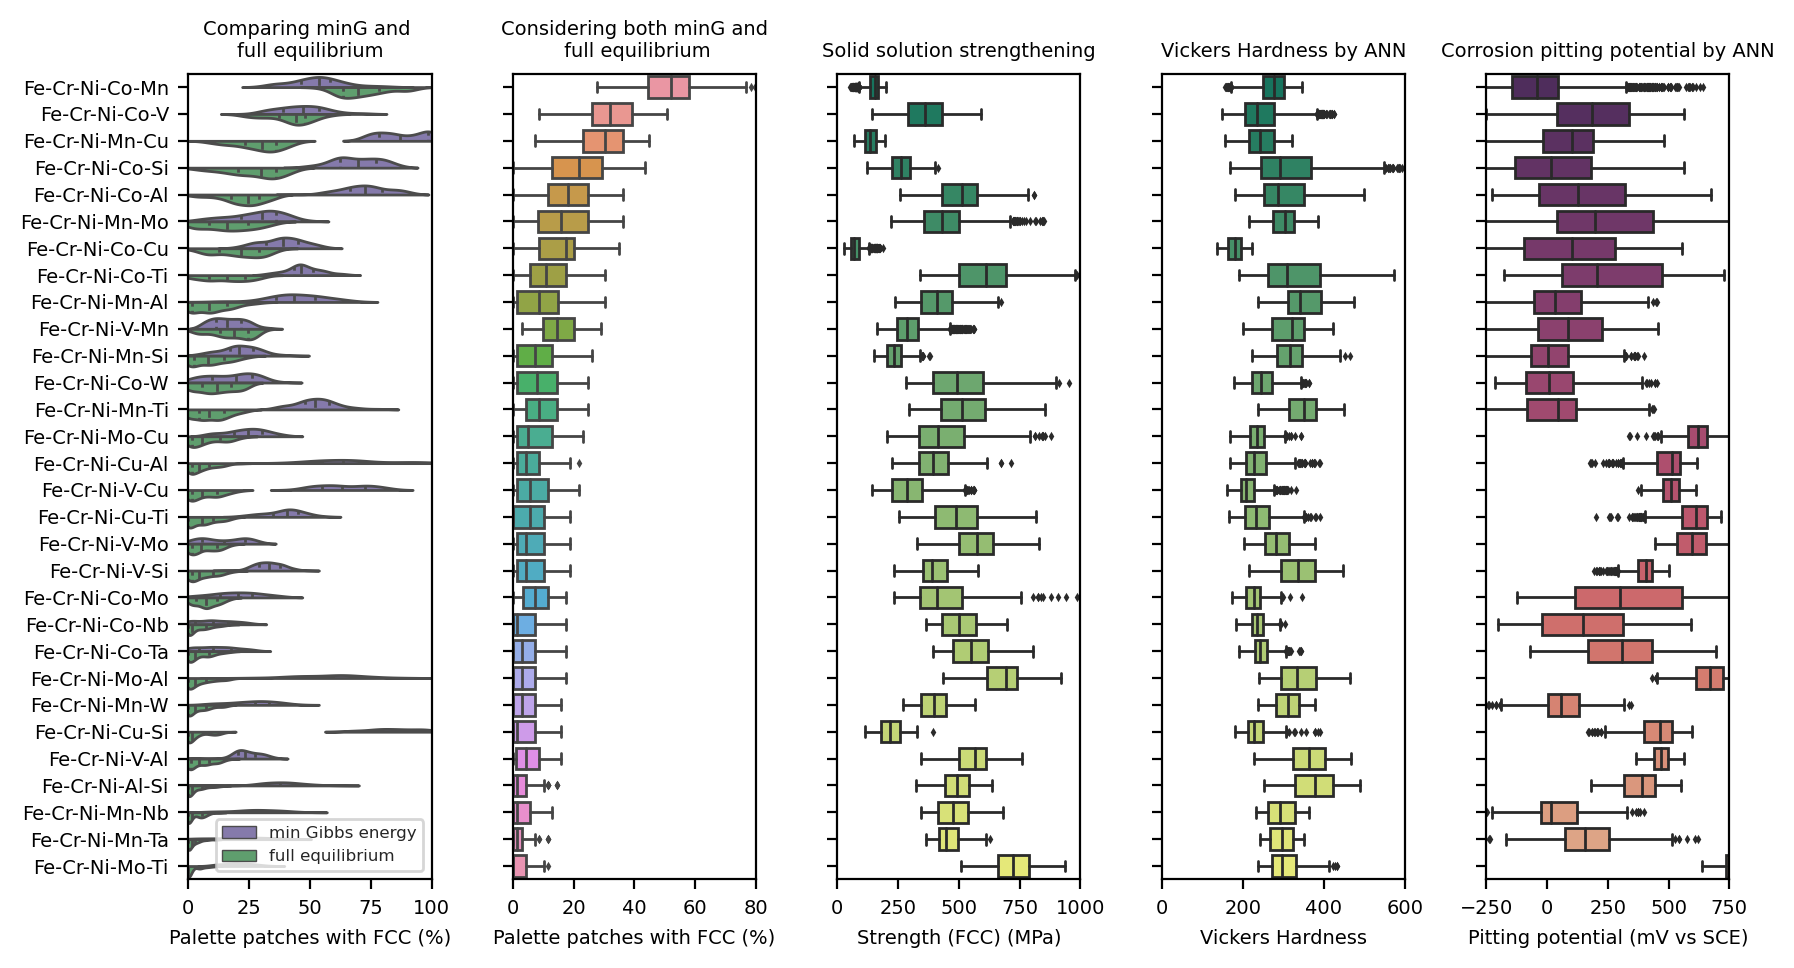

In [8]:
fig, axs = plt.subplots(ncols=5, figsize=(9, 5), dpi=200)
sns.set_theme(style="whitegrid")
font_size = 7

sns.violinplot(data=df_fcc_sns_30, x="Gmin_vs_eq_FCC_fraction", y="compo_A_B_C_D_E", hue="minG vs.full equil.",
               split=True, inner="quart", linewidth=1,
               palette={"min Gibbs energy": "m", "full equilibrium": "g"}, ax=axs[0])
# sns.despine(left=True, ax=axs[0])
title = "Comparing minG and full equilibrium"
wrapped_title = "\n".join(title[i:i+19] for i in range(0, len(title), 19))
axs[0].set_title(wrapped_title, fontsize=font_size)
axs[0].set_xlabel('Palette patches with FCC (%)', fontsize=font_size)
axs[0].set_ylabel(None)
axs[0].legend(fontsize=font_size-1, loc='lower right')
axs[0].set_xlim([0, 100])
axs[0].tick_params(axis='both', labelsize=font_size)


sns.boxplot(data=df_fcc_sns_30, x="Gmin_eq_FCC_fraction", y="compo_A_B_C_D_E",
            linewidth=1, fliersize=1, ax=axs[1])  # palette="summer"
# sns.despine(left=True, ax=axs[1])
title = "Considering both minG and full equilibrium"
wrapped_title = "\n".join(title[i:i+25] for i in range(0, len(title), 25))
axs[1].set_title(wrapped_title, fontsize=font_size)
axs[1].set_xlabel('Palette patches with FCC (%)', fontsize=font_size)
axs[1].set_ylabel(None)
axs[1].set_xlim([0, 80])
axs[1].set_yticklabels([])
axs[1].tick_params(axis='both', labelsize=font_size)


sns.boxplot(data=df_SSS_sns_30, x="sigma_SSS_FCC", y="compo_A_B_C_D_E",
            linewidth=1, fliersize=1, ax=axs[2], palette="summer")
# sns.despine(left=True, ax=axs[2])
axs[2].set_title('Solid solution strengthening', fontsize=font_size)
axs[2].set_xlabel('Strength (FCC) (MPa)', fontsize=font_size)
axs[2].set_ylabel(None)
axs[2].set_yticklabels([])
axs[2].set_xlim([0, 1000])
axs[2].tick_params(axis='both', labelsize=font_size)


sns.boxplot(data=df_H1_C2_sns_30, x="H1_new_pred_KFold_mean_FCC",
            y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="summer")
# sns.despine(left=True, ax=axs[2])
axs[3].set_title('Vickers Hardness by ANN', fontsize=font_size)
axs[3].set_xlabel('Vickers Hardness', fontsize=font_size)
axs[3].set_ylabel(None)
axs[3].set_yticklabels([])
axs[3].set_xlim([0, 600])
axs[3].tick_params(axis='both', labelsize=font_size)

sns.boxplot(data=df_H1_C2_sns_30, x="C2_new_pred_KFold_mean_FCC",
            y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[4], palette="flare_r")
# sns.despine(left=True, ax=axs[2])
axs[4].set_title('Corrosion pitting potential by ANN', fontsize=font_size)
axs[4].set_xlabel('Pitting potential (mV vs SCE)', fontsize=font_size)
axs[4].set_ylabel(None)
axs[4].set_yticklabels([])
axs[4].set_xlim([-300, 800])
axs[4].tick_params(axis='both', labelsize=font_size)

plt.tight_layout()
plt.savefig('sns_plot_30', bbox_inches='tight')
plt.show()


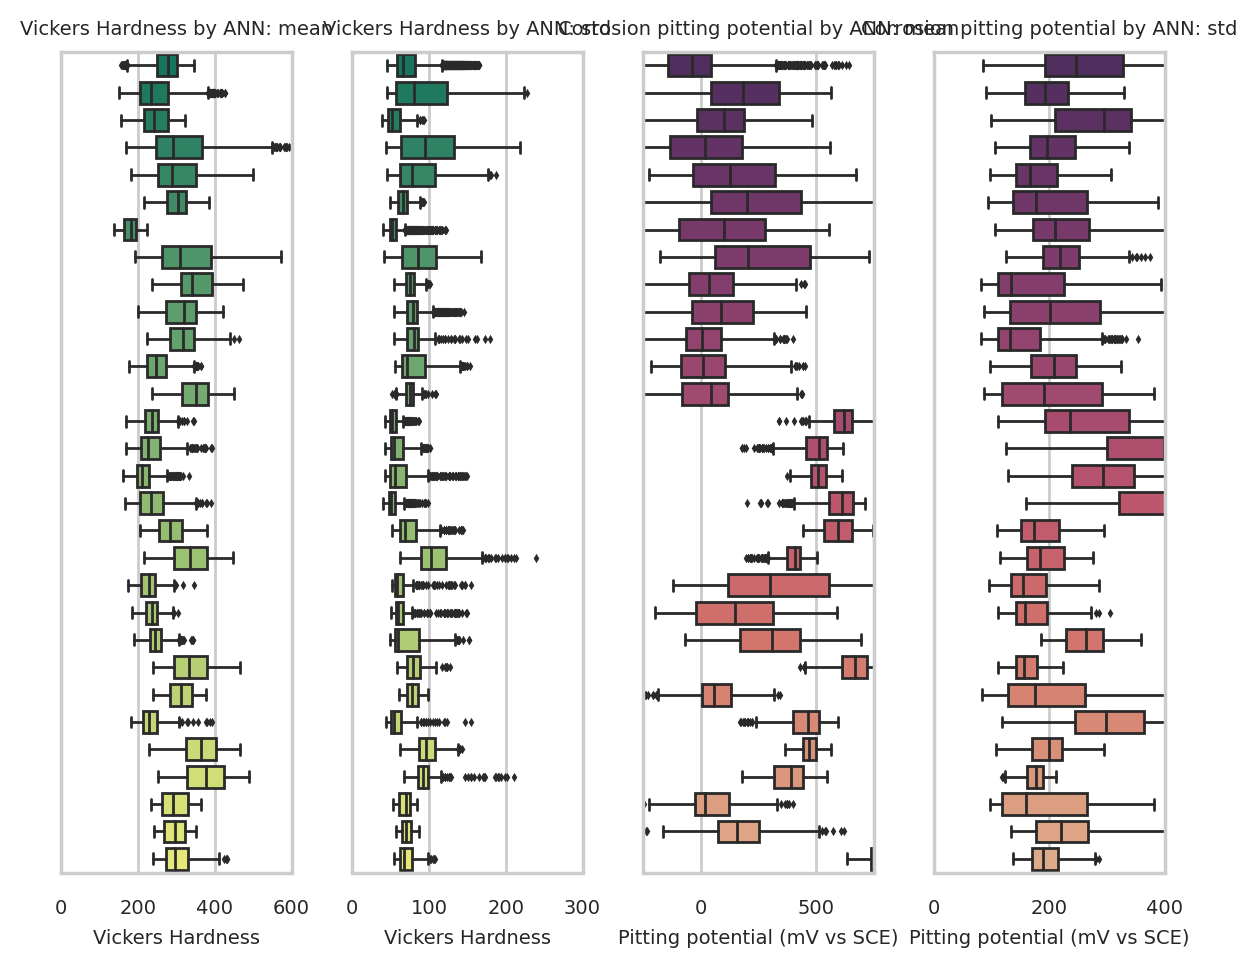

In [9]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 5), dpi=200)
sns.set_theme(style="whitegrid")
font_size = 7

sns.boxplot(data=df_H1_C2_sns_30, x="H1_new_pred_KFold_mean_FCC",
            y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[0], palette="summer")
# sns.despine(left=True, ax=axs[2])
axs[0].set_title('Vickers Hardness by ANN: mean', fontsize=font_size)
axs[0].set_xlabel('Vickers Hardness', fontsize=font_size)
axs[0].set_ylabel(None)
axs[0].set_yticklabels([])
axs[0].set_xlim([0, 600])
axs[0].tick_params(axis='both', labelsize=font_size)

sns.boxplot(data=df_H1_C2_sns_30, x="H1_new_pred_KFold_std_FCC",
            y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[1], palette="summer")
# sns.despine(left=True, ax=axs[2])
axs[1].set_title('Vickers Hardness by ANN: std', fontsize=font_size)
axs[1].set_xlabel('Vickers Hardness', fontsize=font_size)
axs[1].set_ylabel(None)
axs[1].set_yticklabels([])
axs[1].set_xlim([0, 300])
axs[1].tick_params(axis='both', labelsize=font_size)

sns.boxplot(data=df_H1_C2_sns_30, x="C2_new_pred_KFold_mean_FCC",
            y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[2], palette="flare_r")
# sns.despine(left=True, ax=axs[2])
axs[2].set_title('Corrosion pitting potential by ANN: mean',
                 fontsize=font_size)
axs[2].set_xlabel('Pitting potential (mV vs SCE)', fontsize=font_size)
axs[2].set_ylabel(None)
axs[2].set_yticklabels([])
axs[2].set_xlim([-300, 800])
axs[2].tick_params(axis='both', labelsize=font_size)

sns.boxplot(data=df_H1_C2_sns_30, x="C2_new_pred_KFold_std_FCC",
            y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="flare_r")
# sns.despine(left=True, ax=axs[2])
axs[3].set_title('Corrosion pitting potential by ANN: std', fontsize=font_size)
axs[3].set_xlabel('Pitting potential (mV vs SCE)', fontsize=font_size)
axs[3].set_ylabel(None)
axs[3].set_yticklabels([])
axs[3].set_xlim([0, 400])
axs[3].tick_params(axis='both', labelsize=font_size)

plt.tight_layout()
# plt.savefig('sns_plot_30', bbox_inches='tight')
plt.show()


### All alloys by max FCC fraction per palette


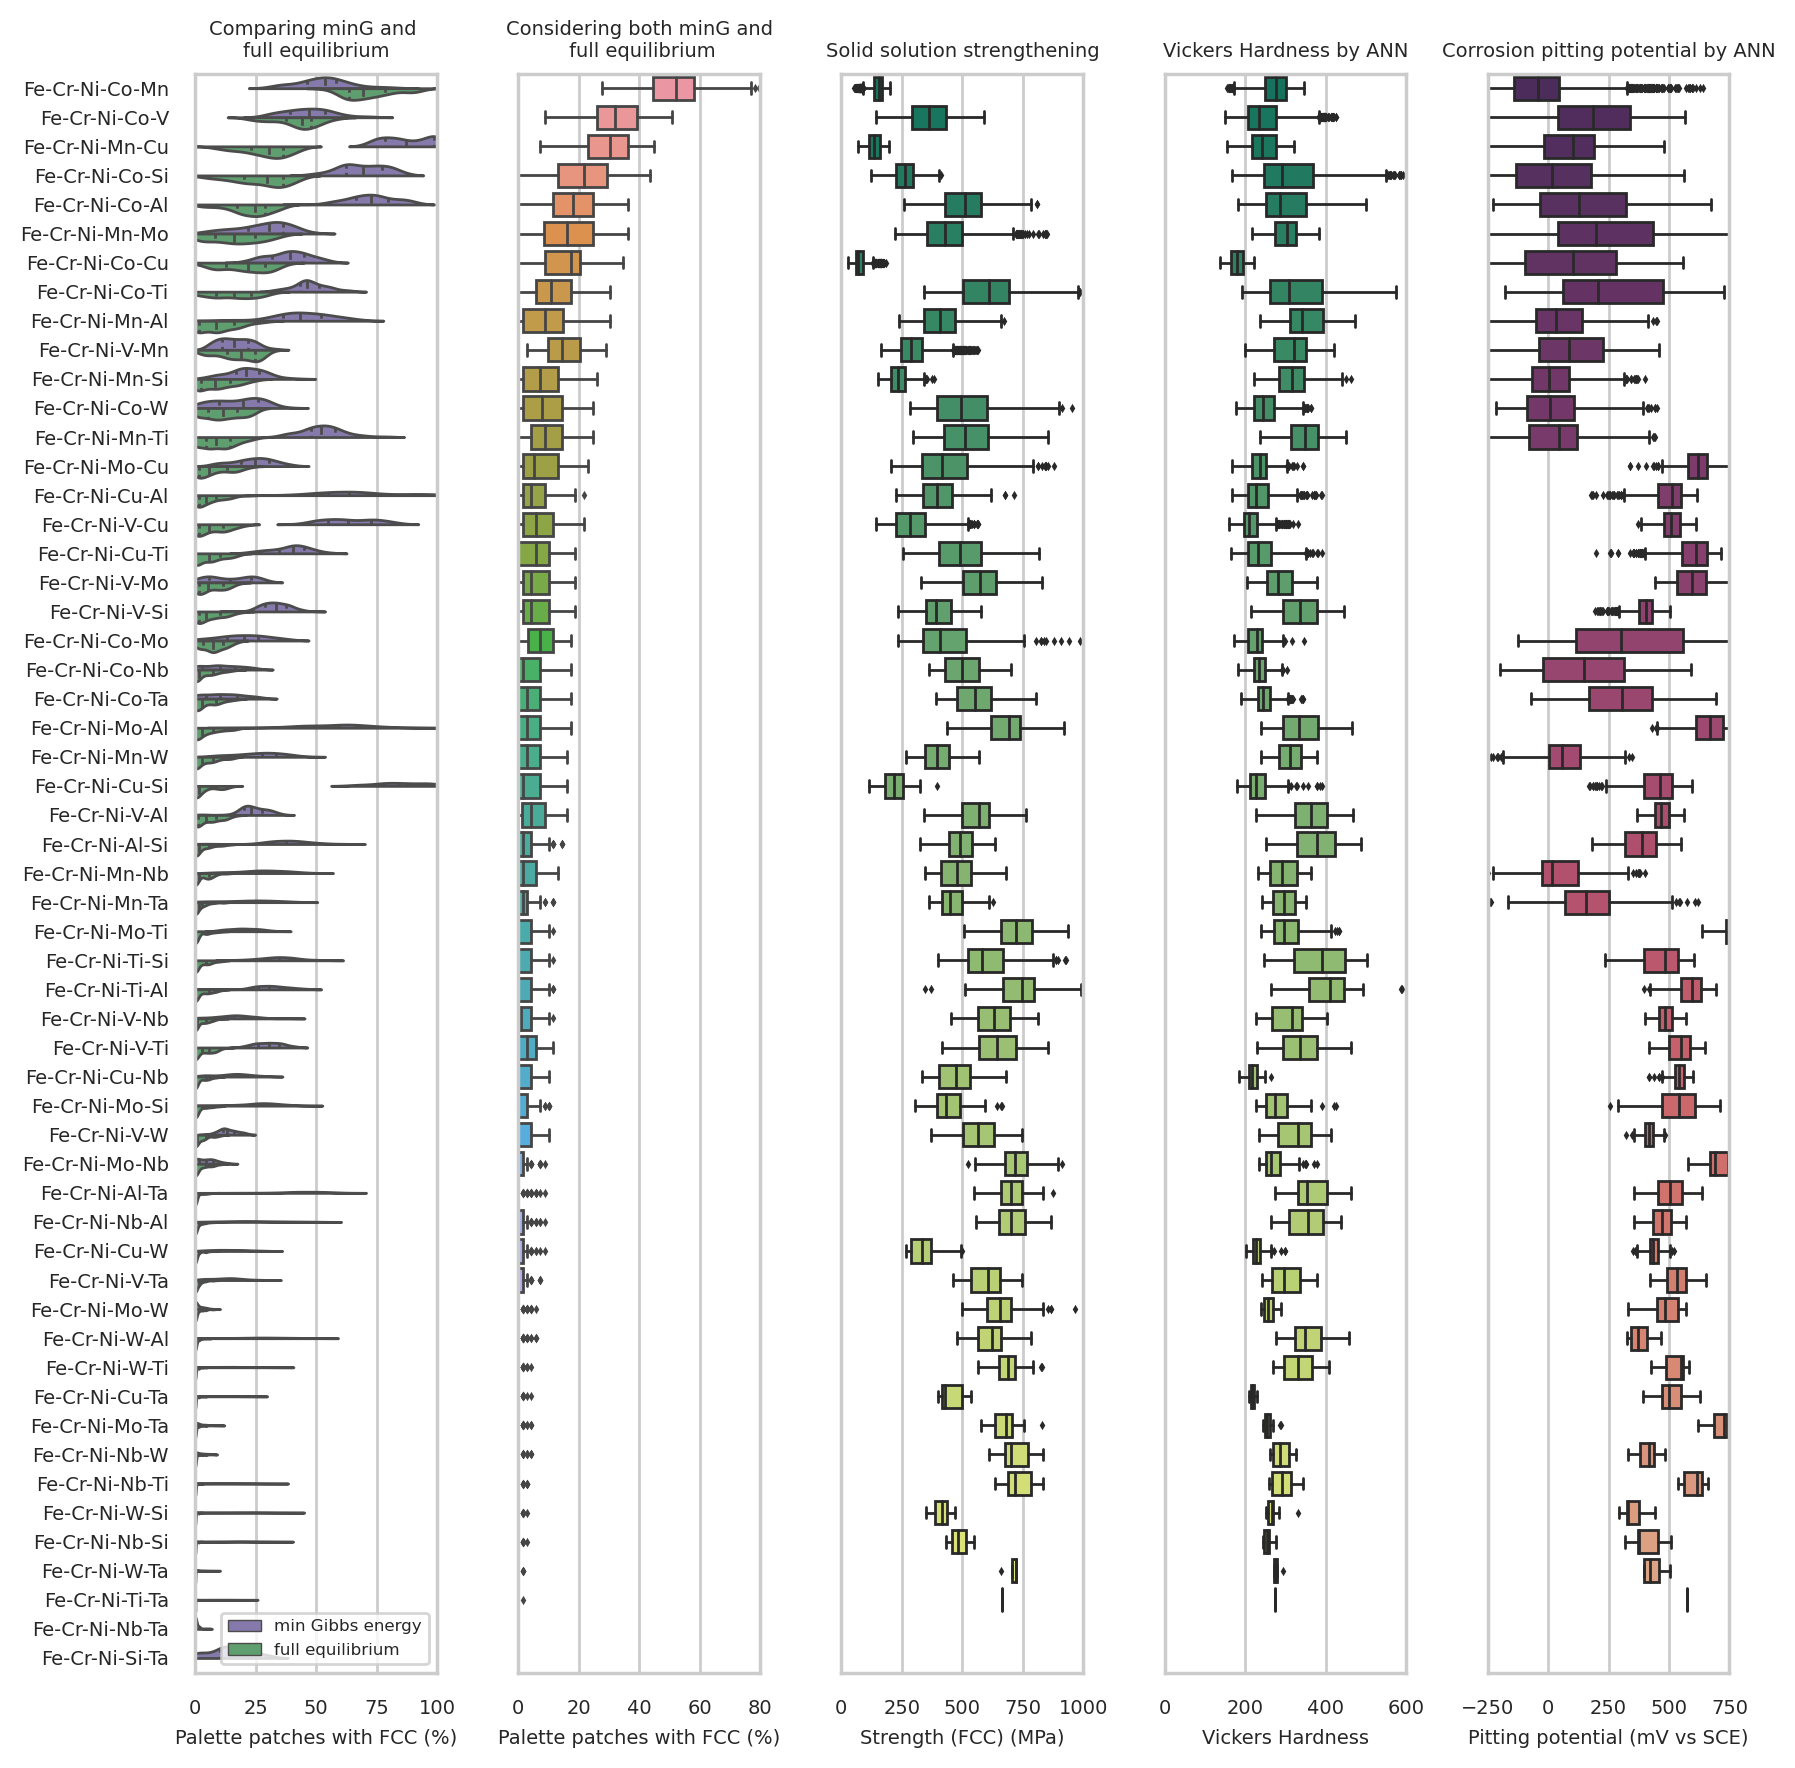

In [10]:
fig, axs = plt.subplots(ncols=5, figsize=(9, 9), dpi=200)
sns.set_theme(style="whitegrid")
font_size = 7

sns.violinplot(data=df_fcc_sns, x="Gmin_vs_eq_FCC_fraction", y="compo_A_B_C_D_E", hue="minG vs.full equil.",
               split=True, inner="quart", linewidth=1,
               palette={"min Gibbs energy": "m", "full equilibrium": "g"}, ax=axs[0])
# sns.despine(left=True, ax=axs[0])
title = "Comparing minG and full equilibrium"
wrapped_title = "\n".join(title[i:i+19] for i in range(0, len(title), 19))
axs[0].set_title(wrapped_title, fontsize=font_size)
axs[0].set_xlabel('Palette patches with FCC (%)', fontsize=font_size)
axs[0].set_ylabel(None)
axs[0].legend(fontsize=font_size-1, loc='lower right')
axs[0].set_xlim([0, 100])
axs[0].tick_params(axis='both', labelsize=font_size)


sns.boxplot(data=df_fcc_sns, x="Gmin_eq_FCC_fraction", y="compo_A_B_C_D_E",
            linewidth=1, fliersize=1, ax=axs[1])  # palette="summer"
# sns.despine(left=True, ax=axs[1])
title = "Considering both minG and full equilibrium"
wrapped_title = "\n".join(title[i:i+25] for i in range(0, len(title), 25))
axs[1].set_title(wrapped_title, fontsize=font_size)
axs[1].set_xlabel('Palette patches with FCC (%)', fontsize=font_size)
axs[1].set_ylabel(None)
axs[1].set_xlim([0, 80])
axs[1].set_yticklabels([])
axs[1].tick_params(axis='both', labelsize=font_size)


sns.boxplot(data=df_SSS_sns, x="sigma_SSS_FCC", y="compo_A_B_C_D_E",
            linewidth=1, fliersize=1, ax=axs[2], palette="summer")
# sns.despine(left=True, ax=axs[2])
axs[2].set_title('Solid solution strengthening', fontsize=font_size)
axs[2].set_xlabel('Strength (FCC) (MPa)', fontsize=font_size)
axs[2].set_ylabel(None)
axs[2].set_yticklabels([])
axs[2].set_xlim([0, 1000])
axs[2].tick_params(axis='both', labelsize=font_size)


sns.boxplot(data=df_H1_C2_sns, x="H1_new_pred_KFold_mean_FCC",
            y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="summer")
# sns.despine(left=True, ax=axs[2])
axs[3].set_title('Vickers Hardness by ANN', fontsize=font_size)
axs[3].set_xlabel('Vickers Hardness', fontsize=font_size)
axs[3].set_ylabel(None)
axs[3].set_yticklabels([])
axs[3].set_xlim([0, 600])
axs[3].tick_params(axis='both', labelsize=font_size)

sns.boxplot(data=df_H1_C2_sns, x="C2_new_pred_KFold_mean_FCC",
            y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[4], palette="flare_r")
# sns.despine(left=True, ax=axs[2])
axs[4].set_title('Corrosion pitting potential by ANN', fontsize=font_size)
axs[4].set_xlabel('Pitting potential (mV vs SCE)', fontsize=font_size)
axs[4].set_ylabel(None)
axs[4].set_yticklabels([])
axs[4].set_xlim([-300, 800])
axs[4].tick_params(axis='both', labelsize=font_size)


plt.tight_layout()
plt.savefig('sns_plot_full', bbox_inches='tight')
plt.show()
